<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Capstone Project: Finding a New York City Neighborhood similar to DC Shaw</font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore the venues in New-York City and DC Shaw Neighborhood</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [29]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#!conda install -c conda-forge shapely --yes 
#from shapely.wkt import loads as load_wkt
!conda install -c anaconda openpyxl --yes
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2020.4.5.1-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi               anaconda::certifi-2020.4.5.1-py36_0 --> conda-forge::certifi-2020.4.5.1-py36h9f0ad1d_0
  openssl               anaconda::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1g-h516909a_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - openpyxl


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.4.5~ --> anaconda::ca-certificates-2020.1.1-0
 

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [30]:
#!wget -q -O 'DC_data.json' https://opendata.arcgis.com/datasets/f6c703ebe2534fc3800609a07bad8f5b_17.geojson
#!wget -q -O 'ATL_data.json' https://opendata.arcgis.com/datasets/d6298dee8938464294d3f49d473bcf15_196.geojson
NYC_neighborhoods = pd.read_excel (r'/resources/labs/Capstone/NYC_ll_df_comb.xlsx')

In [31]:
NYC_neighborhoods.columns = ['Borough', 'NTA_Code', 'Neighborhood', 'Latitude', 'Longitude', 'Year', 'pop_2010']
NYC_neighborhoods=NYC_neighborhoods.drop(['Year'], axis=1)
NYC_neighborhoods.head(10)

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010
0,Bronx,BX31,Allerton-Pelham Gardens,40.865788,-73.859319,28903
1,Bronx,BX05,Bedford Park-Fordham North,40.870185,-73.885512,54415
2,Bronx,BX06,Belmont,40.857277,-73.888452,27378
3,Bronx,BX07,Bronxdale,40.852723,-73.861726,35538
4,Bronx,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.819014,-73.848027,53686
5,Bronx,BX01,Claremont-Bathgate,40.831428,-73.901199,31078
6,Bronx,BX13,Co-Op City,40.874294,-73.829939,43752
7,Bronx,BX63,West Concourse,40.834284,-73.915589,39282
8,Bronx,BX14,East Concourse-Concourse Village,40.824780,-73.915847,62284
9,Bronx,BX17,East Tremont,40.842696,-73.887356,43423


#### Load DC data

Next, let's load the data.

In [32]:
filename = '/resources/labs/Capstone/NYC_Crime.csv'
df_NYCC = pd.read_csv(filename)
df_NYCC=df_NYCC.drop(['pop_2010', 'Violent_crimes'], axis=1)

In [33]:
df_NYCC

,Borough,Crime_2010_per1000
0,Bronx,14.0
1,Brooklyn,11.0
2,Manhattan,16.6
3,Queens,8.8
4,Staten Island,5.2


In [34]:
NYC_neighborhoods= pd.merge(NYC_neighborhoods, df_NYCC, on='Borough')
NYC_neighborhoods.columns = ['Borough', 'NTA_Code', 'Neighborhood', 'Latitude', 'Longitude', 'pop_2010', 'Crime_2010_per1000']
NYC_neighborhoods.head()

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010,Crime_2010_per1000
0,Bronx,BX31,Allerton-Pelham Gardens,40.865788,-73.859319,28903,14.0
1,Bronx,BX05,Bedford Park-Fordham North,40.870185,-73.885512,54415,14.0
2,Bronx,BX06,Belmont,40.857277,-73.888452,27378,14.0
3,Bronx,BX07,Bronxdale,40.852723,-73.861726,35538,14.0
4,Bronx,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.819014,-73.848027,53686,14.0


In [35]:
NYC_neighborhoods.dtypes

Borough                object
NTA_Code               object
Neighborhood           object
Latitude              float64
Longitude             float64
pop_2010                int64
Crime_2010_per1000    float64
dtype: object

#### Importing DC data

#### Use geopy library to get the latitude and longitude values of New York City.

In [36]:
filename = '/resources/labs/Capstone/DC_Neighborhood_Cluster_Demographics.csv'
df_DC = pd.read_csv(filename)
df_DC.columns = ['Borough', 'NTA_Code', 'Neighborhood', 'Latitude', 'Longitude', 'pop_2010', 'Crime_2010_per1000']

In [37]:
df_DC.head()

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010,Crime_2010_per1000
0,DC,1,Adams Morgan,38.919379,-77.047702,18338,8.9
1,DC,2,Columbia Heights,38.928700,-77.031769,47378,13.0
2,DC,3,Shaw,38.921257,-77.023415,12174,17.0
3,DC,4,Georgetown,38.909686,-77.066409,20464,5.0
4,DC,5,Foggy Bottom,38.902386,-77.048975,16160,3.0


####Selecting our origine neighborhood in DC: Shaw

In [38]:
origine_code = 3
origine_DC = df_DC[df_DC['NTA_Code']==origine_code]
origine_name = origine_DC ['Neighborhood'].values[0]
origine_DC

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010,Crime_2010_per1000
2,DC,3,Shaw,38.921257,-77.023415,12174,17.0


In [39]:
#DC_latitude = 38.395
#DC_longitude = -77.0366
address = 'Washington DC'

geolocator = Nominatim(user_agent="DC_explorer")
location = geolocator.geocode(address)
DC_latitude = location.latitude
DC_longitude = location.longitude

print('The geograpical coordinate of Washington DC are {}, {}.'.format(DC_latitude, DC_longitude))

The geograpical coordinate of Washington DC are 38.8949855, -77.0365708.


In [40]:
# create map of New York using latitude and longitude values
map_DC = folium.Map(location=[DC_latitude, DC_longitude], zoom_start=11.4)

# add markers to map
for lat, lng, neighborhood in zip(df_DC['Latitude'], df_DC['Longitude'], df_DC['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    if neighborhood == origine_name:
        fcolor = 'green'
        csize = 10
    else:
        fcolor = 'blue'
        csize = 5
    folium.CircleMarker(
        [lat, lng],
        radius=csize,
        popup=label,
        color=fcolor,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DC)  
    
map_DC

#### Adding origine neighborhood in DC to NYC data

In [41]:
Neighborhoods = NYC_neighborhoods.append(origine_DC, ignore_index = True)
Neighborhoods.head()

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010,Crime_2010_per1000
0,Bronx,BX31,Allerton-Pelham Gardens,40.865788,-73.859319,28903,14.0
1,Bronx,BX05,Bedford Park-Fordham North,40.870185,-73.885512,54415,14.0
2,Bronx,BX06,Belmont,40.857277,-73.888452,27378,14.0
3,Bronx,BX07,Bronxdale,40.852723,-73.861726,35538,14.0
4,Bronx,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.819014,-73.848027,53686,14.0


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [42]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [43]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NYC_neighborhoods['Latitude'], NYC_neighborhoods['Longitude'], NYC_neighborhoods['Borough'], NYC_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [44]:
CLIENT_ID = 'FB2011MW0LW5YNMXRD1ZCSW3ZSH2AONBOFEW2FN2YK1Z321Y' # your Foursquare ID
CLIENT_SECRET = 'KISNJ11S43014YAZGQ30KT50ORWL03KMYCGNSUQTP0C01AGO'  # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FB2011MW0LW5YNMXRD1ZCSW3ZSH2AONBOFEW2FN2YK1Z321Y
CLIENT_SECRET:KISNJ11S43014YAZGQ30KT50ORWL03KMYCGNSUQTP0C01AGO


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

Get the neighborhood's latitude and longitude values.

In [45]:
neighborhood_latitude = Neighborhoods.loc[2, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Neighborhoods.loc[2, 'Longitude'] # neighborhood longitude value

neighborhood_name = Neighborhoods.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Belmont are 40.85727710073895, -73.88845196134804.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [46]:
# type your answer here
LIMIT = 150 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL



'https://api.foursquare.com/v2/venues/explore?&client_id=FB2011MW0LW5YNMXRD1ZCSW3ZSH2AONBOFEW2FN2YK1Z321Y&client_secret=KISNJ11S43014YAZGQ30KT50ORWL03KMYCGNSUQTP0C01AGO&v=20190605&ll=40.85727710073895,-73.88845196134804&radius=500&limit=150'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [47]:
results = requests.get(url).json()
#results.head()

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [48]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [49]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Tino's Delicatessen,Italian Restaurant,40.855882,-73.887166
1,Casa Della Mozzarella,Deli / Bodega,40.855440,-73.887373
2,Full Moon Pizzeria,Pizza Place,40.855506,-73.887557
3,Michaelangelo's Coal Fired Brick Oven Pizza Re...,Italian Restaurant,40.857412,-73.886468
4,Zero Otto Nove,Pizza Place,40.854714,-73.888388


And how many venues were returned by Foursquare?

In [50]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

99 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore the venues in New-York City and DC Shaw Neighborhood

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [52]:
# type your answer here

Neighborhoods_venues = getNearbyVenues(names=Neighborhoods['Neighborhood'],
                                   latitudes=Neighborhoods['Latitude'],
                                   longitudes=Neighborhoods['Longitude']
                                  )



Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [53]:
print(Neighborhoods_venues.shape)
Neighborhoods_venues.head()

(6047, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allerton-Pelham Gardens,40.865788,-73.859319,Domenick's Pizzeria,40.865576,-73.858124,Pizza Place
1,Allerton-Pelham Gardens,40.865788,-73.859319,Bronx Martial Arts Academy,40.865721,-73.857529,Martial Arts Dojo
2,Allerton-Pelham Gardens,40.865788,-73.859319,White Castle,40.866065,-73.862307,Fast Food Restaurant
3,Allerton-Pelham Gardens,40.865788,-73.859319,Dunkin',40.865204,-73.859007,Donut Shop
4,Allerton-Pelham Gardens,40.865788,-73.859319,Sal & Doms Bakery,40.865377,-73.855236,Dessert Shop


In [54]:
cat_summary = Neighborhoods_venues['Venue Category'].value_counts()
#cat_unique = Neighborhoods_venues['Venue Category'].nunique()
#cat_unique.dtypes
#cat_unique.to_frame()

In [55]:
#cat_summary.to_excel (r'/resources/labs/Capstone/cat_summary.xlsx', index = True, header=True)

In [56]:
origine_Venues = Neighborhoods_venues[Neighborhoods_venues['Neighborhood']==origine_name]

In [57]:
origine_summary = origine_Venues['Venue Category'].value_counts()

In [58]:
#LC_summary.to_excel (r'/resources/labs/Capstone/LC_summary.xlsx', index = True, header=True)

Let's check how many venues were returned for each neighborhood

In [59]:
#Neighborhoods_venues.groupby('Neighborhood').count()

#### Let's find out how many unique categories can be curated from all the returned venues

In [60]:
print('There are {} uniques categories.'.format(len(Neighborhoods_venues['Venue Category'].unique())))

There are 375 uniques categories.


In [61]:
Category_grouping = pd.read_excel (r'/resources/labs/Capstone/Category_Grouping.xlsx')

In [62]:
Neighborhoods_venues= pd.merge(Neighborhoods_venues, Category_grouping, on='Venue Category')

In [63]:
Neighborhoods_venues = Neighborhoods_venues[Neighborhoods_venues['New_Category'].notnull()]

In [64]:
Neighborhoods_venues['New_Category'].value_counts()

RESTAURANT                         2343
SPECIALTY  STORE / SERVICE          782
BAR                                 469
BAKERY                              309
GYM / SPORT                         295
COFFEE SHOP                         291
PARK / NATURE LANDMARK              219
GROCERY STORE                       194
PUBLIC TRANSPORTATION               121
HEALTH & BEAUTY SERVICE             116
PHARMACY / DRUGSTORE                110
FINANCIAL SERVICES                  107
THEATER / SHOW                      107
SALON / BARBERSHOP                   78
ART GALLERY                          68
DEPARTMENT STORE                     61
GAS STATION / CONVENIENT  STORE      47
HOTEL                                46
SOUTH ASIAN RESTAURANT               46
PET STORE / SERVICE                  45
BOOKSTORE / LIBRARY                  34
MARKET                               31
SHOPPING MALL                        11
WORSHIP PLACE                         3
FARMING                               1


In [65]:
NB= pd.merge(Neighborhoods_venues, Neighborhoods[['Borough', 'Neighborhood']], on='Neighborhood')
NB[['Borough', 'New_Category', 'Venue']].groupby(['Borough', 'New_Category']).agg(['count'])

Venue
                                              count
Borough       New_Category                         
Bronx         ART GALLERY                         5
              BAKERY                             48
              BAR                                30
              BOOKSTORE / LIBRARY                 1
              COFFEE SHOP                        15
              DEPARTMENT STORE                   20
              FINANCIAL SERVICES                 26
              GAS STATION / CONVENIENT  STORE    14
              GROCERY STORE                      53
              GYM / SPORT                        40
              HEALTH & BEAUTY SERVICE            13
              HOTEL                               1
              MARKET                              7
              PARK / NATURE LANDMARK             21
              PET STORE / SERVICE                 1
              PHARMACY / DRUGSTORE               27
              PUBLIC TRANSPORTATION              47
              RESTAURANT                        366
              SALON / BARBERSHOP                  7
              SHOPPING MALL                       2
              SOUTH ASIAN RESTAURANT              3
              SPECIALTY  STORE / SERVICE         99
              THEATER / SHOW                      2
Brooklyn      ART GALLERY                        17
              BAKERY                             93
              BAR                               161
              BOOKSTORE / LIBRARY                13
              COFFEE SHOP                        97
              DEPARTMENT STORE                   10
              FARMING                             1
              FINANCIAL SERVICES                 29
              GAS STATION / CONVENIENT  STORE    14
              GROCERY STORE                      53
              GYM / SPORT                        74
              HEALTH & BEAUTY SERVICE            31
              HOTEL                               5
              MARKET                              9
              PARK / NATURE LANDMARK             63
              PET STORE / SERVICE                12
              PHARMACY / DRUGSTORE               29
              PUBLIC TRANSPORTATION              12
              RESTAURANT                        640
              SALON / BARBERSHOP                 19
              SHOPPING MALL                       2
              SOUTH ASIAN RESTAURANT             15
              SPECIALTY  STORE / SERVICE        255
              THEATER / SHOW                     32
              WORSHIP PLACE                       1
DC            BAR                                 3
              BOOKSTORE / LIBRARY                 1
              COFFEE SHOP                         1
              GYM / SPORT                         1
              PARK / NATURE LANDMARK              1
              RESTAURANT                         10
              SPECIALTY  STORE / SERVICE          1
              THEATER / SHOW                      3
Manhattan     ART GALLERY                        39
              BAKERY                             64
              BAR                               171
              BOOKSTORE / LIBRARY                19
              COFFEE SHOP                       135
              DEPARTMENT STORE                   15
              FINANCIAL SERVICES                 10
              GAS STATION / CONVENIENT  STORE     4
              GROCERY STORE                      30
              GYM / SPORT                       105
              HEALTH & BEAUTY SERVICE            40
              HOTEL                              31
              MARKET                              9
              PARK / NATURE LANDMARK             73
              PET STORE / SERVICE                21
              PHARMACY / DRUGSTORE               15
              PUBLIC TRANSPORTATION              11
              RESTAURANT                        657
              SALON / BARBERSHOP          

<a id='item3'></a>

In [66]:
Neighborhoods_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category,New_Category
0,Allerton-Pelham Gardens,40.865788,-73.859319,Domenick's Pizzeria,40.865576,-73.858124,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
1,Allerton-Pelham Gardens,40.865788,-73.859319,Domino's Pizza,40.866363,-73.861798,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
2,Allerton-Pelham Gardens,40.865788,-73.859319,Prego's Pizza,40.863841,-73.856599,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
3,Allerton-Pelham Gardens,40.865788,-73.859319,Domenicks's Pizzeria,40.865720,-73.858059,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
4,Bedford Park-Fordham North,40.870185,-73.885512,My Place Family Pizza,40.869262,-73.889476,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
5,Bedford Park-Fordham North,40.870185,-73.885512,Jerome's Pizza,40.873107,-73.889050,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
6,Bedford Park-Fordham North,40.870185,-73.885512,Rocco's Pizza Restaurant,40.867539,-73.883729,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
7,Belmont,40.857277,-73.888452,Full Moon Pizzeria,40.855506,-73.887557,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
8,Belmont,40.857277,-73.888452,Zero Otto Nove,40.854714,-73.888388,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
9,Belmont,40.857277,-73.888452,Bellini's Pizza,40.857071,-73.885350,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT


In [67]:
Neighborhoods_venues['New_Category'].value_counts()

RESTAURANT                         2343
SPECIALTY  STORE / SERVICE          782
BAR                                 469
BAKERY                              309
GYM / SPORT                         295
COFFEE SHOP                         291
PARK / NATURE LANDMARK              219
GROCERY STORE                       194
PUBLIC TRANSPORTATION               121
HEALTH & BEAUTY SERVICE             116
PHARMACY / DRUGSTORE                110
FINANCIAL SERVICES                  107
THEATER / SHOW                      107
SALON / BARBERSHOP                   78
ART GALLERY                          68
DEPARTMENT STORE                     61
GAS STATION / CONVENIENT  STORE      47
HOTEL                                46
SOUTH ASIAN RESTAURANT               46
PET STORE / SERVICE                  45
BOOKSTORE / LIBRARY                  34
MARKET                               31
SHOPPING MALL                        11
WORSHIP PLACE                         3
FARMING                               1


In [68]:
origine_Venues = Neighborhoods_venues[Neighborhoods_venues['Neighborhood']==origine_name]

In [69]:
origine_Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category,New_Category
602,Shaw,38.921257,-77.023415,Roy Boys,38.918265,-77.023068,Fried Chicken Joint,AMERICAN RESTAURANT,RESTAURANT
1744,Shaw,38.921257,-77.023415,Chuck & Billy's Bar,38.925643,-77.023153,Bar,BAR,BAR
1865,Shaw,38.921257,-77.023415,Chipotle Mexican Grill,38.921088,-77.021865,Mexican Restaurant,LATIN AMERICAN RESTAURANT,RESTAURANT
2009,Shaw,38.921257,-77.023415,Potbelly Sandwich Shop,38.920186,-77.021800,Sandwich Place,DELI,RESTAURANT
2010,Shaw,38.921257,-77.023415,Subway,38.920907,-77.021886,Sandwich Place,DELI,RESTAURANT


In [70]:
origine_Venues['New_Category'].value_counts()

RESTAURANT                    10
BAR                            3
THEATER / SHOW                 3
GYM / SPORT                    1
PARK / NATURE LANDMARK         1
COFFEE SHOP                    1
SPECIALTY  STORE / SERVICE     1
BOOKSTORE / LIBRARY            1
Name: New_Category, dtype: int64

In [71]:
Neighborhoods_venues = Neighborhoods_venues[Neighborhoods_venues['New_Category'].isin([
'BAR', 
'RESTAURANT',  
'COFFEE SHOP', 
'GYM / SPORT', 
'GROCERY STORE', 
'SPECIALTY  STORE / SERVICE',
'PUBLIC TRANSPORTATION', 
'BAKERY',
'PARK / NATURE LANDMARK',
'THEATER / SHOW'
])]
Category_count = Neighborhoods_venues.groupby(['Neighborhood', 'New_Category'], as_index=False).agg({'Venue': "count"})
Category_count.columns = ['Neighborhood', 'New_Category', 'Venue_Count']
Neighborhoods_venues['New_Category'].value_counts()
#Category_count

RESTAURANT                    2343
SPECIALTY  STORE / SERVICE     782
BAR                            469
BAKERY                         309
GYM / SPORT                    295
COFFEE SHOP                    291
PARK / NATURE LANDMARK         219
GROCERY STORE                  194
PUBLIC TRANSPORTATION          121
THEATER / SHOW                 107
Name: New_Category, dtype: int64

## 3. Analyze Each Neighborhood

In [72]:
Category_count_onehot = pd.get_dummies(Category_count[['New_Category']], prefix="", prefix_sep="")
Category_count_onehot.columns =[ 
'BAKERY',  
'BAR', 
'COFFEE_SHOP', 
'GROCERY_STORE',
'GYM_SPORT', 
'PARK_NATURE_LANDMARK',
'PUBLIC_TRANSPORTATION', 
'RESTAURANT',  
'SPECIALTY_STORE_SERVICE',
'THEATER_SHOW']
Category_count_onehot.head()

,BAKERY,BAR,COFFEE_SHOP,GROCERY_STORE,GYM_SPORT,PARK_NATURE_LANDMARK,PUBLIC_TRANSPORTATION,RESTAURANT,SPECIALTY_STORE_SERVICE,THEATER_SHOW
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0


In [73]:
print(Category_count_onehot.columns)

Index(['BAKERY', 'BAR', 'COFFEE_SHOP', 'GROCERY_STORE', 'GYM_SPORT',
       'PARK_NATURE_LANDMARK', 'PUBLIC_TRANSPORTATION', 'RESTAURANT',
       'SPECIALTY_STORE_SERVICE', 'THEATER_SHOW'],
      dtype='object')


In [74]:
Category_count = pd.concat([Category_count, Category_count_onehot], axis=1)

In [75]:
Category_count.head()

,Neighborhood,New_Category,Venue_Count,BAKERY,BAR,COFFEE_SHOP,GROCERY_STORE,GYM_SPORT,PARK_NATURE_LANDMARK,PUBLIC_TRANSPORTATION,RESTAURANT,SPECIALTY_STORE_SERVICE,THEATER_SHOW
0,Allerton-Pelham Gardens,BAKERY,1,1,0,0,0,0,0,0,0,0,0
1,Allerton-Pelham Gardens,GROCERY STORE,3,0,0,0,1,0,0,0,0,0,0
2,Allerton-Pelham Gardens,GYM / SPORT,2,0,0,0,0,1,0,0,0,0,0
3,Allerton-Pelham Gardens,PARK / NATURE LANDMARK,1,0,0,0,0,0,1,0,0,0,0
4,Allerton-Pelham Gardens,RESTAURANT,11,0,0,0,0,0,0,0,1,0,0


In [76]:
Category_count['BAR'] = Category_count['BAR'] * Category_count['Venue_Count']
Category_count['RESTAURANT'] = Category_count['RESTAURANT'] * Category_count['Venue_Count']
Category_count['COFFEE_SHOP'] = Category_count['COFFEE_SHOP' ] * Category_count['Venue_Count']
Category_count['SPECIALTY_STORE_SERVICE' ] = Category_count['SPECIALTY_STORE_SERVICE' ] * Category_count['Venue_Count']
Category_count['GYM_SPORT'] =  Category_count['GYM_SPORT'] * Category_count['Venue_Count']
Category_count['GROCERY_STORE'] = Category_count['GROCERY_STORE' ] * Category_count['Venue_Count']
Category_count['PUBLIC_TRANSPORTATION'] = Category_count['PUBLIC_TRANSPORTATION'] * Category_count['Venue_Count']
Category_count['BAKERY'] = Category_count['BAKERY'] * Category_count['Venue_Count']
Category_count['PARK_NATURE_LANDMARK'] = Category_count['PARK_NATURE_LANDMARK'] * Category_count['Venue_Count']
Category_count['THEATER_SHOW'] = Category_count['THEATER_SHOW'] * Category_count['Venue_Count']

In [77]:
Category_count.head()

,Neighborhood,New_Category,Venue_Count,BAKERY,BAR,COFFEE_SHOP,GROCERY_STORE,GYM_SPORT,PARK_NATURE_LANDMARK,PUBLIC_TRANSPORTATION,RESTAURANT,SPECIALTY_STORE_SERVICE,THEATER_SHOW
0,Allerton-Pelham Gardens,BAKERY,1,1,0,0,0,0,0,0,0,0,0
1,Allerton-Pelham Gardens,GROCERY STORE,3,0,0,0,3,0,0,0,0,0,0
2,Allerton-Pelham Gardens,GYM / SPORT,2,0,0,0,0,2,0,0,0,0,0
3,Allerton-Pelham Gardens,PARK / NATURE LANDMARK,1,0,0,0,0,0,1,0,0,0,0
4,Allerton-Pelham Gardens,RESTAURANT,11,0,0,0,0,0,0,0,11,0,0


In [78]:
Category_count0 = Category_count.groupby(['Neighborhood'], as_index=False).agg({'RESTAURANT' : sum,
                                                                                'BAR' : sum, 
                                                                                'COFFEE_SHOP' : sum, 
                                                                                'SPECIALTY_STORE_SERVICE' : sum, 
                                                                                'GYM_SPORT' : sum, 
                                                                                'GROCERY_STORE' : sum, 
                                                                                'PUBLIC_TRANSPORTATION' : sum, 
                                                                                'BAKERY' : sum,
                                                                                'PARK_NATURE_LANDMARK' : sum,
                                                                                'THEATER_SHOW' : sum}
                                                                                )

In [79]:
Category_count0.head()

,Neighborhood,RESTAURANT,BAR,COFFEE_SHOP,SPECIALTY_STORE_SERVICE,GYM_SPORT,GROCERY_STORE,PUBLIC_TRANSPORTATION,BAKERY,PARK_NATURE_LANDMARK,THEATER_SHOW
0,Allerton-Pelham Gardens,11,0,0,3,2,3,0,1,1,0
1,Annadale-Huguenot-Prince's Bay-Eltingville,7,1,0,0,0,0,1,1,0,0
2,Arden Heights,1,0,1,1,1,0,0,0,1,0
3,Astoria,45,18,3,12,5,2,1,6,0,0
4,Auburndale,6,2,0,5,1,1,0,0,0,0


In [80]:
Neighborhoods_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category,New_Category
0,Allerton-Pelham Gardens,40.865788,-73.859319,Domenick's Pizzeria,40.865576,-73.858124,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
1,Allerton-Pelham Gardens,40.865788,-73.859319,Domino's Pizza,40.866363,-73.861798,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
2,Allerton-Pelham Gardens,40.865788,-73.859319,Prego's Pizza,40.863841,-73.856599,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
3,Allerton-Pelham Gardens,40.865788,-73.859319,Domenicks's Pizzeria,40.865720,-73.858059,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT
4,Bedford Park-Fordham North,40.870185,-73.885512,My Place Family Pizza,40.869262,-73.889476,Pizza Place,FAST FOOD RESTAURANT,RESTAURANT


In [133]:
Neighborhoods_final= pd.merge(Neighborhoods, Category_count0, on='Neighborhood')
Neighborhoods_final['BAKERY'] = Neighborhoods_final['BAKERY'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['BAR'] = Neighborhoods_final['BAR'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['COFFEE_SHOP'] = Neighborhoods_final['COFFEE_SHOP'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['GROCERY_STORE'] = Neighborhoods_final['GROCERY_STORE'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['GYM_SPORT'] = Neighborhoods_final['GYM_SPORT'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['PUBLIC_TRANSPORTATION'] = Neighborhoods_final['PUBLIC_TRANSPORTATION'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['RESTAURANT'] = Neighborhoods_final['RESTAURANT'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['SPECIALTY_STORE_SERVICE'] = Neighborhoods_final['SPECIALTY_STORE_SERVICE'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['PARK_NATURE_LANDMARK'] = Neighborhoods_final['PARK_NATURE_LANDMARK'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final['THEATER_SHOW'] = Neighborhoods_final['THEATER_SHOW'] * 10000/ Neighborhoods_final['pop_2010']
Neighborhoods_final.head()

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010,Crime_2010_per1000,RESTAURANT,BAR,COFFEE_SHOP,SPECIALTY_STORE_SERVICE,GYM_SPORT,GROCERY_STORE,PUBLIC_TRANSPORTATION,BAKERY,PARK_NATURE_LANDMARK,THEATER_SHOW
0,Bronx,BX31,Allerton-Pelham Gardens,40.865788,-73.859319,28903,14.0,3.805833,0.000000,0.00000,1.037955,0.691970,1.037955,0.000000,0.345985,0.345985,0.0
1,Bronx,BX05,Bedford Park-Fordham North,40.870185,-73.885512,54415,14.0,3.859230,0.367546,0.00000,0.551319,0.367546,0.367546,0.183773,0.183773,0.183773,0.0
2,Bronx,BX06,Belmont,40.857277,-73.888452,27378,14.0,18.993352,1.826284,1.09577,4.748338,0.365257,1.095770,0.365257,2.922054,0.000000,0.0
3,Bronx,BX07,Bronxdale,40.852723,-73.861726,35538,14.0,1.969723,0.000000,0.00000,0.281389,0.281389,0.562778,0.000000,0.000000,0.281389,0.0
4,Bronx,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.819014,-73.848027,53686,14.0,0.558805,0.000000,0.00000,0.000000,0.186268,0.186268,0.186268,0.000000,0.186268,0.0


In [135]:
Neighborhoods_final.head()

,Borough,NTA_Code,Neighborhood,Latitude,Longitude,pop_2010,Crime_2010_per1000,RESTAURANT,BAR,COFFEE_SHOP,SPECIALTY_STORE_SERVICE,GYM_SPORT,GROCERY_STORE,PUBLIC_TRANSPORTATION,BAKERY,PARK_NATURE_LANDMARK,THEATER_SHOW
0,Bronx,BX31,Allerton-Pelham Gardens,40.865788,-73.859319,28903,14.0,3.805833,0.000000,0.00000,1.037955,0.691970,1.037955,0.000000,0.345985,0.345985,0.0
1,Bronx,BX05,Bedford Park-Fordham North,40.870185,-73.885512,54415,14.0,3.859230,0.367546,0.00000,0.551319,0.367546,0.367546,0.183773,0.183773,0.183773,0.0
2,Bronx,BX06,Belmont,40.857277,-73.888452,27378,14.0,18.993352,1.826284,1.09577,4.748338,0.365257,1.095770,0.365257,2.922054,0.000000,0.0
3,Bronx,BX07,Bronxdale,40.852723,-73.861726,35538,14.0,1.969723,0.000000,0.00000,0.281389,0.281389,0.562778,0.000000,0.000000,0.281389,0.0
4,Bronx,BX09,Soundview-Castle Hill-Clason Point-Harding Park,40.819014,-73.848027,53686,14.0,0.558805,0.000000,0.00000,0.000000,0.186268,0.186268,0.186268,0.000000,0.186268,0.0


SELECT THE CATEGORIES INCLUDED IN THE ANALYSIS:
'Neighborhood', 
'BAR', 
'AMERICAN_RESTAURANT',  
'ASIAN_RESTAURANT',  
'LATIN_AMERICAN_RESTAURANT', 
'COFFEE_SHOP', 
'SPECIALTY_STORE_SERVICE', 
'GYM_SPORT', 
'GROCERY_STORE', 
'PUBLIC_TRANSPORTATION', 
'ITALIAN_RESTAURANT',
'BAKERY',
'FAST_FOOD_RESTAURANT',
'INTERNATIONAL_RESTAURANT',
'PARK_NATURE_LANDMARK', 'THEATER_SHOW', 'Crime_2010_per1000'


In [82]:
Npanel0 = Neighborhoods_final.drop(['Borough', 'NTA_Code', 'Latitude', 'Longitude', 'pop_2010'], axis=1)
Npanel = Npanel0[['Neighborhood', 
'RESTAURANT',  
'BAR',  
'SPECIALTY_STORE_SERVICE', 
'THEATER_SHOW',
'GYM_SPORT']]
#'Crime_2010_per1000'
#Npanel = Npanel0[Npanel0.columns[0,2:7,1]] 
Npanel.head()

,Neighborhood,RESTAURANT,BAR,SPECIALTY_STORE_SERVICE,THEATER_SHOW,GYM_SPORT
0,Allerton-Pelham Gardens,3.805833,0.000000,1.037955,0.0,0.691970
1,Bedford Park-Fordham North,3.859230,0.367546,0.551319,0.0,0.367546
2,Belmont,18.993352,1.826284,4.748338,0.0,0.365257
3,Bronxdale,1.969723,0.000000,0.281389,0.0,0.281389
4,Soundview-Castle Hill-Clason Point-Harding Park,0.558805,0.000000,0.000000,0.0,0.186268


## 4. Cluster Neighborhoods

In [83]:
from sklearn.preprocessing import StandardScaler

X = Npanel.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
#cluster_dataset

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


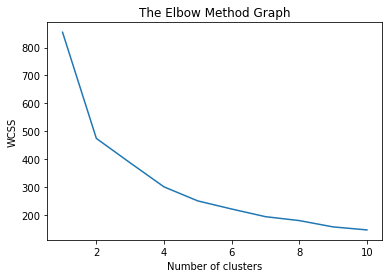

In [84]:
#3 Using the elbow method to find out the optimal number of #clusters. 
#KMeans class from the sklearn library.

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss=[]

#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list.

for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
        
#i above is between 1-10 numbers. init parameter is the random 
#initialization method  
#we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
#find the final clusters when the K-meands algorithm is running. we #enter the default value of 300
#the next parameter is n_init which is the number of times the #K_means algorithm will be run with
#different initial centroid.

    kmeans.fit(cluster_dataset)

#kmeans algorithm fits to the X dataset

    wcss.append(kmeans.inertia_)

#kmeans inertia_ attribute is:  Sum of squared distances of samples 
#to their closest cluster center.
#print(wcss)

#4.Plot the elbow graph
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [85]:
num_clusters = 6

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0 5 0 0 0 0 0 5 5 0
 0 0 5 3 0 0 0 1 1 0 0 2 0 0 0 4 2 0 0 4 0 2 2 1 0 0 0 0 1 0 2 1 0 0 0 0 0
 0 5 5 2 0 1 4 0 1 1 5 2 2 4 0 5 2 3 0 2 2 2 5 2 0 0 5 2 5 2 5 5 0 0 2 5 0
 0 0 0 0 2 2 0 0 0 0 2 2 0 2 0 5 0 0 0 5 0 5 0 2 2 0 0 0 2 2 0 0 0 0 0 0 0
 0 0 0 5 0 0 2 0 0 0 0 0 5 0 0 0 0 0 5 0 5 0 4]


In [86]:
Npanel["Labels"] = labels
Npanel.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,RESTAURANT,BAR,SPECIALTY_STORE_SERVICE,THEATER_SHOW,GYM_SPORT,Labels
0,Allerton-Pelham Gardens,3.805833,0.000000,1.037955,0.0,0.691970,2
1,Bedford Park-Fordham North,3.859230,0.367546,0.551319,0.0,0.367546,0
2,Belmont,18.993352,1.826284,4.748338,0.0,0.365257,1
3,Bronxdale,1.969723,0.000000,0.281389,0.0,0.281389,0
4,Soundview-Castle Hill-Clason Point-Harding Park,0.558805,0.000000,0.000000,0.0,0.186268,0


In [87]:
Borough = Neighborhoods[['Borough', 'Neighborhood', 'Latitude', 'Longitude']]
Npanel= pd.merge(Borough, Npanel, on='Neighborhood')

In [132]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

Npanel1 = Npanel[Npanel['Neighborhood']!= "Shaw"]

# add markers to map
for lat, lng, borough, neighborhood, lbl in zip(Npanel1['Latitude'], Npanel1['Longitude'], Npanel1['Borough'], Npanel['Neighborhood'], Npanel1['Labels']):
    label = 'Cluster {} - {}, {}'.format(lbl, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    if lbl== 0:
        dcolor = 'purple'
    elif lbl== 1:
        dcolor = 'red'
    elif lbl== 2:
        dcolor = 'green'
    elif lbl== 3:
        dcolor = 'yellow'
    elif lbl== 4:
        dcolor = 'blue'
    elif lbl==5:
        dcolor = 'cyan'
    else:
        dcolor = 'black'

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=dcolor,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## 5. Examine Clusters

In [89]:
Npanel['Labels'].value_counts()

0    103
2     30
5     21
1     10
4      5
3      2
Name: Labels, dtype: int64

In [100]:
Npanel.groupby('Labels', as_index=False).agg({'RESTAURANT': ['mean', 'min', 'max'], 'BAR': ['mean', 'min', 'max'], 
                              'SPECIALTY_STORE_SERVICE': ['mean', 'min', 'max'], 'THEATER_SHOW': ['mean', 'min', 'max'],
                             'GYM_SPORT': ['mean', 'min', 'max']})

Labels RESTAURANT                            BAR                      \
               mean       min        max      mean       min       max   
0      0   1.714309  0.000000   5.231413  0.167137  0.000000  1.176941   
1      1  11.057347  8.083191  18.993352  3.401469  0.353832  7.053252   
2      2   3.543183  0.475082   7.291790  0.584427  0.000000  1.504721   
3      3  11.443914  9.779951  13.107878  2.271643  1.047852  3.495434   
4      4   6.803071  2.927353   9.969707  2.637233  0.813154  4.391358   
5      5   5.976007  3.669994   9.150327  1.350503  0.334102  2.691388   

  SPECIALTY_STORE_SERVICE                     THEATER_SHOW            \
                     mean       min       max         mean       min   
0                0.575375  0.000000  2.013288     0.014194  0.000000   
1                4.188939  2.945441  6.015144     0.448271  0.000000   
2                1.484978  0.000000  4.211314     0.147048  0.000000   
3                5.721957  4.889976  6.553939     1.266317  0.436929   
4                1.820643  0.821423  3.067602     2.432356  2.300702   
5                1.417322  0.303711  2.858776     0.119409  0.000000   

            GYM_SPORT                      
        max      mean       min       max  
0  0.542138  0.160788  0.000000  0.768684  
1  1.071888  0.760881  0.000000  1.769160  
2  0.579794  0.983221  0.372086  2.339072  
3  2.095704  4.149531  3.492840  4.806222  
4  2.615291  1.189986  0.821423  1.961468  
5  1.046651  0.271098  0.000000  0.913075

In [109]:
sumCluster = Npanel.groupby('Labels', as_index=False).agg({'RESTAURANT': ['mean'], 'BAR': ['mean'], 
                              'SPECIALTY_STORE_SERVICE': ['mean'], 'THEATER_SHOW': ['mean'],
                             'GYM_SPORT': ['mean']})
sumCluster.columns = sumCluster.columns.droplevel(level=0)

sumCluster.columns=["Labels", "Restaurant", "Bar", "Specialty", "Theater_Show", "Gym_Sport"]

sumCluster


,Labels,Restaurant,Bar,Specialty,Theather_Show,Gym_Sport
0,0,1.714309,0.167137,0.575375,0.014194,0.160788
1,1,11.057347,3.401469,4.188939,0.448271,0.760881
2,2,3.543183,0.584427,1.484978,0.147048,0.983221
3,3,11.443914,2.271643,5.721957,1.266317,4.149531
4,4,6.803071,2.637233,1.820643,2.432356,1.189986
5,5,5.976007,1.350503,1.417322,0.119409,0.271098


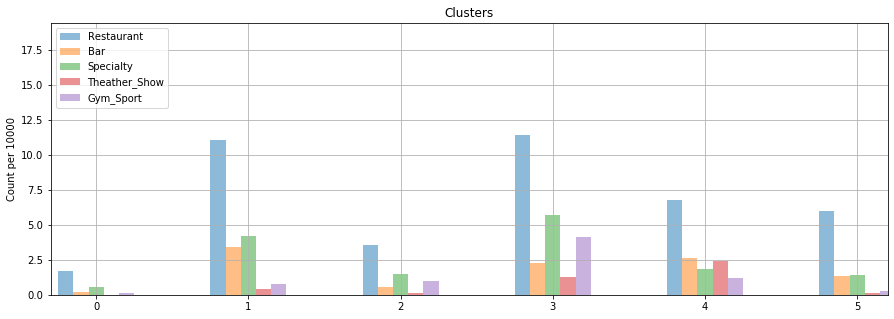

In [131]:
# Setting the positions and width for the bars
pos = list(range(len(sumCluster['Restaurant']))) 
width = 0.10
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['Restaurant'] data,
        sumCluster['Restaurant'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#EE3224', 
        # with label the first value in Labels
        label=sumCluster['Labels'][0]) 

# Create a bar with Bar data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['Bar'] data,
        sumCluster['Bar'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#F78F1E', 
        # with label the second value in Labels
        label=sumCluster['Labels'][1]) 

# Create a bar with specialty data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        sumCluster['Specialty'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#FFC222', 
        # with label the third value in labels
        label=sumCluster['Labels'][2]) 

# Create a bar with Theatther data,
# in position pos + some width buffer,
plt.bar([p + width*3 for p in pos], 
        #using df['post_score'] data,
        sumCluster['Theather_Show'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#FFC222', 
        # with label the third value in first_name
        label=sumCluster['Labels'][2]) 


# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*4 for p in pos], 
        #using df['post_score'] data,
        sumCluster['Gym_Sport'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#FFC222', 
        # with label the third value in first_name
        label=sumCluster['Labels'][2]) 


# Set the y axis label
ax.set_ylabel('Count per 10000')

# Set the chart's title
ax.set_title('Clusters')

# Set the position of the x ticks
ax.set_xticks([p + 2 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(sumCluster['Labels'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(sumCluster['Restaurant'] + sumCluster['Bar'] + sumCluster['Specialty'])] )

# Adding the legend and showing the plot
plt.legend(['Restaurant', 'Bar', 'Specialty', "Theater_Show", "Gym_Sport"], loc='upper left')
plt.grid()
plt.show()

In [91]:
selected_cluster_number = Npanel[Npanel['Neighborhood']==origine_name]['Labels'].values[0]
Selected_Cluster = Npanel[Npanel['Labels']==selected_cluster_number]
Selected_Cluster

,Borough,Neighborhood,Latitude,Longitude,RESTAURANT,BAR,SPECIALTY_STORE_SERVICE,THEATER_SHOW,GYM_SPORT,Labels
52,Brooklyn,East Williamsburg,40.708492,-73.938858,6.147901,4.391358,1.463786,2.342057,0.878272,4
56,Brooklyn,Fort Greene,40.688527,-73.972906,9.969707,2.684152,3.067602,2.300702,1.150351,4
80,Manhattan,Clinton,40.759101,-73.996119,6.756168,2.833232,1.961468,2.615291,1.961468,4
87,Manhattan,Lincoln Square,40.773529,-73.985338,2.927353,0.813154,1.788938,2.439461,1.138415,4
170,DC,Shaw,38.921257,-77.023415,8.214227,2.464268,0.821423,2.464268,0.821423,4


In [92]:

Selected_Cluster['Area'] = Selected_Cluster['Neighborhood'] + " - " + Selected_Cluster['Borough']
Selected_Cluster.reset_index(inplace = True) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
NY_Selected_Cluster = Selected_Cluster[Selected_Cluster['Neighborhood']!= "Shaw"]
NY_Selected_Cluster.head()

,index,Borough,Neighborhood,Latitude,Longitude,RESTAURANT,BAR,SPECIALTY_STORE_SERVICE,THEATER_SHOW,GYM_SPORT,Labels,Area
0,52,Brooklyn,East Williamsburg,40.708492,-73.938858,6.147901,4.391358,1.463786,2.342057,0.878272,4,East Williamsburg - Brooklyn
1,56,Brooklyn,Fort Greene,40.688527,-73.972906,9.969707,2.684152,3.067602,2.300702,1.150351,4,Fort Greene - Brooklyn
2,80,Manhattan,Clinton,40.759101,-73.996119,6.756168,2.833232,1.961468,2.615291,1.961468,4,Clinton - Manhattan
3,87,Manhattan,Lincoln Square,40.773529,-73.985338,2.927353,0.813154,1.788938,2.439461,1.138415,4,Lincoln Square - Manhattan


In [94]:
# create map and display it
latitude0 = NY_Selected_Cluster.loc[0, 'Latitude']
longitude0 = NY_Selected_Cluster.loc[0, 'Longitude']

# create map of New York using latitude and longitude values
map_NYC = folium.Map(location=[latitude0, longitude0], zoom_start=11.4)

# instantiate a feature group for the incidents in the dataframe
Matches = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, nbh in zip(NY_Selected_Cluster.Latitude, NY_Selected_Cluster.Longitude, NY_Selected_Cluster.Neighborhood):
    if nbh == 'Fort Greene':
        fcolor = 'green'
    else:
        fcolor = 'blue'
        
    Matches.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=15, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color=fcolor,
            fill_opacity=0.6
        )
    )
    
# display the map of NYC
map_NYC

# add pop-up text to each marker on the map
latitudes = list(NY_Selected_Cluster.Latitude)
longitudes = list(NY_Selected_Cluster.Longitude)
labels = list(NY_Selected_Cluster.Area)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_NYC)    
    
# add incidents to map
map_NYC.add_child(Matches)